In [3]:
import torch 
from types import SimpleNamespace
import numpy as np
import os

from loader import TorsionLoader
from Unet1D import Unet1D
from backbone import ConvBackbone1D
from diffusion import VPDiffusion


<font size="3">The directory contains information about paths and naming conventions.</font>

In [4]:
directory = SimpleNamespace(model_path="../saved_models/",
                            data_path="../data/aib9.npy",
                            sample_path="../samples/",
                            identifier="aib9"
                           )

<font size="3">Here we initialize our __TorsionLoader__ object (torsion angles of the Aib9 peptide) and our deep learning architecture which will parameterize the score (a __1D Unet__).</font>

In [5]:
loader = TorsionLoader(directory.data_path)

resnet_block_groups = 8 # model size
num_torsions = loader.__getitem__(0).shape[-1]
model_dim = int(np.ceil(num_torsions/resnet_block_groups) * resnet_block_groups)

print(f"The torsion data has shape {tuple(loader.data.shape)}.")
print(f"There are {num_torsions} torsion angles and {resnet_block_groups} resnet block groups,")
print(f"so the model should have {model_dim} dimensions")

model = Unet1D(dim=model_dim,
               channels=1,
               resnet_block_groups=resnet_block_groups,
               learned_sinusoidal_cond=True,
               learned_sinusoidal_dim=16
              )

The torsion data has shape (500000, 1, 18).
There are 18 torsion angles and 8 resnet block groups,
so the model should have 24 dimensions


<font size="3">The __Backbone__ class is simply a wrapper around the architecture used to predict the score. It automatically initializes optimizers and learning rate schedulers, and has methods to save and load models from files. It also handles upsampling and downsampling of data to be compatible with the model.</font>

In [6]:
backbone = ConvBackbone1D(model=model, # model
                          data_shape=num_torsions, # data shape
                          target_shape=model_dim, # network shape
                          num_dims=len(loader.data.shape),
                          lr=1e-4
                         )

<font size="3">The __VPDiffusion__ class implements the diffusion process in __[Score-Based Generative Modeling through Stochastic Differential Equations](https://openreview.net/pdf/ef0eadbe07115b0853e964f17aa09d811cd490f1.pdf)__. In the paper, the authors derive three SDEs with gaussian stationary distributions: the Variance Exploding (VE) SDE, the Variance Preserving (VP) SDE, and the sub-Variance preserving (sub-VP) SDE. 
</font>

<font size="3">Each SDE differs in their choice of drift and and noise coefficients.
</font>

<font size="3">The VP-SDE has the form
</font>

<font size="3">
$$
\mathrm{d}\mathbf{x} = -\frac{1}{2}\beta(t) \mathbf{x}\mathrm{d}t + \sqrt{\beta(t)}d\mathbf{w}.
$$
</font>
<br>
<font size="3">where $\beta(t)$ is a monotonically increasing function of $t$. Since the drift coefficient $f(x,t) = \frac{1}{2}\beta(t)\mathbf{x}$ is linear in $\mathbf{x}$, the transition kernels have a simple closed-form solutions:
</font>

<font size="3">$$
\mathcal{N}\left(\mathbf{x}_t | \mathbf{x}_0\right) = \mathcal{N}\left(e^{-\frac{1}{2}\int_0^t \beta(s)ds}\mathbf{x}_0 \; \Big|\;(1-e^{-\frac{1}{2}\int_0^t \beta(s)ds}) \mathbf{I}\right).
$$
</font>

<font size="3">It is often easier to work with $\alpha_t = e^{-\frac{1}{2}\int_0^t \beta(s)ds}$ directly rather than $\beta(t)$, which is the approach we will take here. We use the polynomial noise parameterization in Hoogeboom et. al.
</font>
<font size="3">The __VPDiffusion__ class has methods which apply the transition kernels $p(x_t|x_0)$, $q(x_0|x_t)$, and $p(x_{t+1}|x_t)$ to the data. These transition kernels characterize the discrete-time forward ($p$) and reverse ($q$) SDEs. This is the Markov chain formulation originally given in __[Deep Unsupervised Learning using Nonequilibrium Thermodynamics](http://proceedings.mlr.press/v37/sohl-dickstein15.pdf), [Denoising Diffusion Probabilistic Models](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf)__, and __[Denoising Diffusion Implicit Models](https://proceedings.neurips.cc/paper_files/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf)__.
</font>

<font size="3">The discrete (or continuous) time forward SDE can be evaluated in a single step as
    $$
    \mathbf{x}_t = \sqrt{\alpha_{t}}\mathbf{x}_0 + \sqrt{1-\alpha_t}\epsilon
    $$
    since the above kernel has closed form. Note that the original sample can be reconstructed given $\mathbf{x}_t$ and $\epsilon$ by solving for $\mathbf{x}_0$ (this reconstruction is typically denoted as $\mathbf{\hat{x}}^0_t$, and is important for inference when the true $\mathbf{x}_0$ does not exist or is unknown.
</font>

<font size="3">Less straightforwardly, the reverse SDE can be discretized as
    $$\mathbf{x}_{t+1} = \sqrt{\alpha_{t-1}}\left( \frac{\mathbf{x}_t - \sqrt{1-\alpha_t}\mathbf{\epsilon}_\theta^{(t)}(\mathbf{x}_t)}{\sqrt{\alpha_t}}\right) + \sqrt{1 − \alpha_{t-1} - \sigma_t^2}\epsilon_\theta^{(t)}(\mathbf{x}_t) + \sigma_t \epsilon_t,$$ where $\epsilon_t$ is isotropic gaussian noise, and the first term inside the parentheses is $\mathbf{\hat{x}}_0^{(t)}$ &ndash; the network's prediction of $\mathbf{x}_0$ conditional on the information present at timestep $t$. The second term points back towards the noisy sample $\mathbf{x}_t$, so that the process of moving towards $\mathbf{x}_0$ is gradual. The term $\sigma_t$ can be chosen freeley. A choice of $\sigma_t = \sqrt{(1-\alpha_{t-1})/({1-\alpha_t})}\sqrt{1-\alpha_t/\alpha_{t-1}}$ corresponds to the original DDPM implementation, while choosing $\sigma_t = 0$ makes the generative process deterministic, turning the reverse-diffusion SDE into an ODE. 
</font>

<font size="3">The implementation of __VPDiffusion__ uses this update equation with $\sigma_t=0$ to transform noise into data.
</font>






In [7]:
diffusion = VPDiffusion(num_diffusion_timesteps=100)

<font size="3">Diffusion models can be trained with variational or score-matching objectives. In fact, the two loss functions only differ by a multiplicative factor relating to the parameterization of the noise schedule. The score-matching loss and simpler and more widely used in the community, so we will use it here. The score-matching loss is 
$$
\mathcal{L} =\sum\nolimits_{\mathbb{E}(\mathbf{x}_0 \sim p(\mathbf{x}_0), \epsilon \sim \mathcal{N}(0, \mathbf{I}))} \lvert \lvert \epsilon_\theta^{(t)}(\mathbf{x}_t) - \epsilon \rvert \rvert^2.
$$
And $\epsilon_\theta^{(t)}(\mathbf{x}_t, \alpha_t)$ is the prediction of the noise which was added to the original sample $\mathbf{x}_0$ to produce $\mathbf{x}_t$
</font>


<font size="3">Oftentimes the network is trained on the score-matching loss, and the variational loss (see [__Variational Diffusion Models__](https://openreview.net/pdf?id=2LdBqxc1Yv)) is computed during sampling to find log-probabilities (free energies). So, training a diffusion model is simple. First randomly choose a sample $\mathbf{x}_0$ and add randomly sampled noise $\epsilon \sim \mathcal{N}(0, \mathbf{I})$. Then compute $\mathbf{x}_t$ using $\mathbf{x}_0$, $\epsilon$, and the noise schedule $\alpha_t$. Finally, train a neural network to estimate $\epsilon$ given $\mathbf{x}_t$ using the objective above.  
</font>  


In [8]:
def train_loop(train_loader, backbone, diffusion, num_epochs=50):
    
    def l2_loss(x, x_pred):
        return (x - x_pred).pow(2).sum((1,2)).pow(0.5).mean()
    
    for epoch in range(num_epochs):
        for i, b in enumerate(train_loader, 0):

            # sample set of times
            t = torch.randint(low=0, 
                          high=diffusion.num_diffusion_timesteps, 
                          size=(b.size(0),)).long()

            # corrupt data according to noise schedule
            b_t, e_0 = diffusion.forward_kernel(b, t)

            # predict noise and original data
            b_0, e_t = diffusion.reverse_kernel(b_t, t, backbone, "x0")

            # evaluate loss and do backprop
            loss = l2_loss(b_t, b_0)
            backbone.optim.zero_grad()
            loss.backward()
            backbone.optim.step()

            if i % 100 == 0:
                print(f"step: {i}, loss {loss.detach():.3f}")
        backbone.save_state(directory, epoch)

In [ ]:
train_loader = torch.utils.data.DataLoader(loader, batch_size=512, shuffle=True)

# training the diffusion model
train_loop(train_loader, backbone, diffusion)

<font size="3">Sampling amounts to generating random noise and iteratively solving the update equation above using the trained network.</font>

In [37]:
backbone.load_model(directory, 5)

In [38]:
def sample_batch(batch_size, loader, diffusion, backbone, pred_type="x0"):
    
    def sample_prior(batch_size, shape):
        "Generates samples of gaussian noise"
        prior_sample =  torch.randn(batch_size, *shape[1:], dtype=torch.float)
        return prior_sample

    def get_adjacent_times(times):
        """
        Pairs t with t+1 for all times in the time-discretization
        of the diffusion process.
        """
        times_next = torch.cat((torch.Tensor([0]).long(), times[:-1]))
        return list(zip(reversed(times), reversed(times_next)))

    xt = sample_prior(batch_size, loader.data.shape)
    time_pairs = get_adjacent_times(diffusion.times)

    for t, t_next in time_pairs:
        print(int(t))
        t = torch.Tensor.repeat(t, batch_size)
        t_next = torch.Tensor.repeat(t_next, batch_size)
        xt_next = diffusion.reverse_step(xt, t, t_next, backbone, pred_type=pred_type)
        xt = xt_next
    return xt

def save_batch(batch, save_prefix, save_idx):
    os.makedirs(directory.sample_path, exist_ok=True)
    file = os.path.join(directory.sample_path, f"{save_prefix}_idx={save_idx}.npz")
    np.savez_compressed(file, data=batch)

def sample_loop(num_samples, batch_size, save_prefix, loader, diffusion, backbone):
    
    # computing number of runs required to produce num_samples with batch_size constraint
    n_runs = max(num_samples//batch_size, 1)
    if num_samples <= batch_size:
        batch_size = num_samples
        
    # iteratively sampling and saving
    with torch.no_grad():
        for save_idx in range(n_runs):
            x0 = sample_batch(batch_size, loader, diffusion, backbone)
            save_batch(x0, save_prefix, save_idx)

In [ ]:
sample_loop(50000, 10000, "aib9", loader, diffusion, backbone)

In [33]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [18]:
loader.data.numpy().shape

(500000, 1, 18)

In [41]:
pca = PCA(2)
MD_data = loader.data.numpy().squeeze()
pca_torsions = pca.fit_transform(MD_data)

In [29]:
diffusion_data = np.concatenate([np.load(f.path)['data'].squeeze() 
                                 for f in os.scandir(directory.sample_path) if f.is_file()])

In [31]:
pca_diffusion = pca.transform(diffusion_data)

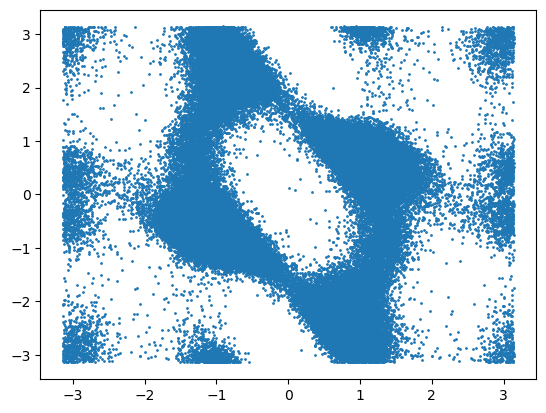

In [42]:
plt.scatter(MD_data[:,0], MD_data[:,1], s=1)

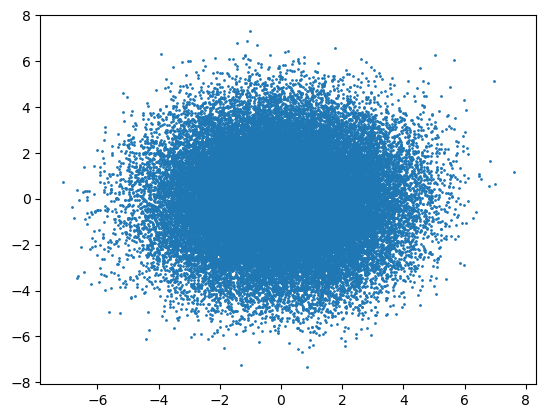

In [45]:
plt.scatter(diffusion_data[:,2], diffusion_data[:,3], s=1)